# CS 8321 Final Project - Advanced Ethics Investigation in Embeddings

Lab Members: Ryan Schaefer, Will Landin, Rick Lattin

### Introduction

Being college students facing graduation, entering the job market in 2024 already presents many challenges, online applications are becoming a new standard and larger companies like Google see upwards of 3 million applications a year and rising. Recent university graduates are often told that finding the right job for you is not only hard work but sometimes a little bit of luck as well. We wanted to determine how much of the perceived “luck” is actually a result of bias.

To handle large applicant pools more efficiently, many companies employ machine learning models to screen applicants’ resumes prior to a manual review. While these models can save employers time and resources, they can be problematic. Graduates and people with perfect qualifications for a job position can, unfortunately, be filtered out for what seems to be no reason at all. If a resume screening model is biased against someone based on something in their resume, that could significantly harm their chances of getting the job, even if they are the perfect candidate. 

An important part of many models that could be a source of such biases is the embeddings used to help models understand the meanings of words. This paper aims to analyze potential biases found in resumes, by comparing sentiment classifiers trained with two of the more popular static and non-context embeddings: GloVe and ConceptNet Numberbatch.
 
In a previous lab experiment, we determined that racial bias is mitigated when using contextualized word embedding such as BERT. The goal of this paper is to analyze these static word embeddings such as Glove, and ConceptNet Numberbatch to identify and explore any shortcomings given the resume context to see the extent and limitations of using these static embeddings.  

Another motivation was a personal story told by an old professor we encountered at another University. This professor was a Persian man with the first name of Mohammed. He graduated from school with a master's degree in chemistry at 17 years old and was excited to get hired to a lab to continue his work. Unfortunately, he did not find work which was very bizarre to himself and to the professors he earned his degree from. But in hindsight, he told us that this very well could have been due to recent fear induced by the September 11th attacks, as he was looking for work from 2001 until 2008.
For many years he had not heard back and was not getting hired anywhere he applied. He decided to change the name on his resume to “Marcus” from “Mohammed” and immediately started getting responses from research labs wanting to hire him. Mohammed was a brilliant man who had all the qualifications to work and contribute to leading research in his field but was denied due to his own name. We hope that by identifying these biases we can prevent the discrimination that exists and help identify and reduce the bias word embeddings have. - Mohammed ****** Chemistry Professor at Santa Monica College 

#### Related work

This is not the first study to look at resume classifiers or embedding bias. One such study was conducted by Gagandeep et al. in 2023, resulting in the paper titled “Evaluating and mitigating gender bias in machine learning based resume filtering.” They used masking to obscure gender-specific words prior to evaluating a resume. They found that about 15% of the resumes in the dataset they used were affected by gender bias, and masking the gender-specific words increased their model’s accuracy by 1.2%. Gagandeep’s work shows that masking is a viable option to reduce bias in resume classifiers which we will try our own version of here.

Many of the methods we will be testing with was inspired by the following blogpost and jupyer notebook:  
https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/ 



Related work citations:

https://link.springer.com/article/10.1007/s11042-023-16552-x

https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/

https://doi.org/10.1145/3386392.3399569



This study aims to address the following research questions:
- How do sentiment classifiers trained on GloVe and ConceptNet Numberbatch embeddings differ in how the inclusion/exclusion of potentially biased words affects the predicted sentiment?
- Which types of bias potentially found in resumes, such as gender, religion, race, or educational background, have the most influence on the classifiers?
- Does masking out biased words give resumes a more neutral predicted sentiment?

To address these questions, we will train two sentiment classifiers on the Sentiment140 tweets dataset (https://www.kaggle.com/datasets/kazanova/sentiment140), one with GloVe and one with ConceptNet Numberbatch. These classifiers will be 1-dimensional convolutional neural networks (CNNs) so that they use some context from the sentences, but not as much as a transformer so that we do not dilute the embeddings too much. We will then analyze bias with many experiments. 

To begin we want to mask all flagged information from the existing resume dataset, from there we will see if there are any areas in particular to focus in on for our broader research. Specifically we will mask out potentially biased words from different categories to see if the classifiers predict the masked sentences to have a more neutral sentiment.

Next we want to conduct experiments that we hope will reflect actual resume filtering simulations. In these experiments, we will add potentially biased words (gendered names, names of universities, etc) to neutral sentiment resumes to see if the classifiers predict the modified sentences have a stronger positive or negative sentiment and measure/graph the differences the sentiments were to the base sentence. 

We hypothesize that both classifiers will be biased, but the classifier trained with ConceptNet Numberbatch will generally be less biased than the classifier trained with GloVe, because ConceptNet Numberbatch was designed with bias mitigation in mind, whereas GloVe was solely trained on statistical co-occurrences of words. We also hypothesize that masking out potentially biased words will neutralize the predicted sentiments, improving the usability of such models for resume screening.

Please see the bottom of the notebook for the additional analyses we plan to execute in the future


### Environment Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
from nltk import word_tokenize
import json
import re
import scipy.stats.distributions as dist
from scipy.stats import ranksums
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings

warnings.simplefilter("ignore", UserWarning)
tf.random.set_seed(8321)
np.random.seed(8321)

## Cleaning Data and Training Models

In [11]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [44]:
cn_embeddings = load_embeddings("../Data/numberbatch-en-19.08.txt")
print("ConceptNet Numberbatch shape:", cn_embeddings.shape)

gl_embeddings = load_embeddings("../Data/glove.840B.300d.txt")
print("GloVe shape:", gl_embeddings.shape)

ConceptNet Numberbatch shape: (516782, 300)
GloVe shape: (2196018, 300)


In [45]:
def pre_process_input_data(filepath='../Data/tweets.csv',encoding='cp1252',num_samples=None,random_state=None): #Change encoding if not on windows
    tweets = pd.read_csv(filepath,encoding=encoding,header=None)
    tweets.columns = ['target','id','date','flag','username','text'] #Change column names to things that make sense
    tweets = tweets.drop(columns=['id','date','flag','username']) #Remove unneeded columns from memory

    tweets = tweets.replace({'target':{0:0,4:1}}) #Dataset has only 0=negative sent, 4=positive sent, remappping to 0,1 respectivly
    if num_samples:
        tweets = tweets.groupby('target').sample(num_samples,random_state=random_state)

    return tweets

TWEET_FILEPATH = '../Data/tweets.csv'
raw_tweet_data = pre_process_input_data(TWEET_FILEPATH,num_samples=100000) #Grab 250,000 of each class (positive and negative sentiment)
raw_tweet_data.head()
#df = pd.read_csv("../Data/tweets.csv")
#df.info()

,target,text
642882,0,I have to stop baking for 2 months so I can di...
472026,0,@ChrisandCal IT'S MORE OF A HANGOVER THAN A NO...
182069,0,what am I gonna do now ? I've just made a wron...
518951,0,Been trying to clear out my left ear with pero...
684812,0,@VerseTheVillain No problem! Sad thing is I ca...


In [46]:
#save the data to a csv file
#raw_tweet_data.to_csv("../Data/downsampledTweets.csv",index=False)
raw_tweet_data.groupby('target').count()

,text
target,
0,100000
1,100000


In [47]:
# split tweet data into training and testing
train_data,test_data,train_targets,test_targets = train_test_split(raw_tweet_data['text'].to_numpy(),raw_tweet_data['target'].to_numpy(),test_size=0.2)

In [48]:
def clean_tweet(tweet):
    # Remove any non-alphabetic characters except basic punctuation
    tweet = re.sub(r"[^a-zA-Z0-9.,'!? ]", '', tweet)
    # Remove any excess whitespace
    tweet = re.sub(r"\s+", ' ', tweet).strip()
    return tweet


In [49]:
X_train = np.array([clean_tweet(t) for t in train_data])
X_test = np.array([clean_tweet(t) for t in test_data])

y_train = train_targets.copy()
y_test = test_targets.copy()

In [50]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = np.max([len(tweet) for tweet in X_train]) # maximum number of words in a tweet

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_train)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X_train)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_ART_LEN)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_ART_LEN)


#y_ohe = keras.utils.to_categorical(y_train, num_classes=2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_train.shape)
print(np.max(X))

Found 147933 unique tokens. Distilled to 147933 top words.
Shape of data tensor: (160000, 155)
Shape of label tensor: (160000,)
147933


In [51]:
print("max tweet length: ", MAX_ART_LEN)

max tweet length:  155


There is an even distribution of positive and negative reviews in the training data, so we do not need to over or under sample the data.

In [61]:

EMBED_SIZE = 300

def create_embeddings_matrix(embeddings):
    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        try:
            embedding_vector = np.array(embeddings.loc[[word]])
        except:
            continue
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
        "Total words found:",found_words, "\n",
        "Percentage:",100*found_words/embedding_matrix.shape[0])
    
    return embedding_matrix


conceptnet_matrix_weights = create_embeddings_matrix(cn_embeddings)


Embedding Shape: (147934, 300) 
 Total words found: 37474 
 Percentage: 25.33156677978017


In [53]:
glove_matrix_weights = create_embeddings_matrix(gl_embeddings) 


Embedding Shape: (147934, 300) 
 Total words found: 53589 
 Percentage: 36.22493814809307


In [88]:
#save the tokenizer to a file
import pickle
with open('../Data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
#np.save("../Data/glove_emb_matrix.npy", glove_matrix_weights )
#np.save("../Data/conceptnet_emb_matrix.npy", conceptnet_matrix_weights)

gl_embedding_matrix = np.load("../Data/glove_emb_matrix.npy")
cn_embedding_matrix = np.load("../Data/conceptnet_emb_matrix.npy")

cn_embedding_matrix = conceptnet_matrix_weights

# save this embedding now
embedding_layer_GL = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    weights=[gl_embedding_matrix],# here is the embedding getting saved
    input_length=MAX_ART_LEN,
    trainable=False
)
embedding_layer_CN = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    weights=[cn_embedding_matrix],# here is the embedding getting saved
    input_length=MAX_ART_LEN,
    trainable=False
)

In [36]:
#dimensions of cn_embedding_matrix
print(cn_embedding_matrix.shape)

print("GloVe Embedding Layer:",gl_embedding_matrix.shape)

(124253, 300)
GloVe Embedding Layer: (124253, 300)


## Creating Models

In [71]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import Subtract, Concatenate
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.001)

def create_model(embedding_layer, filters=128, kernel_size=3, dropout_rate=0.2, learning_rate=1e-3):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [73]:
conceptNetModel = create_model(embedding_layer_CN, kernel_size=5)
conceptNetModelHistory = conceptNetModel.fit(X, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
313/313 [==============================] - 78s 250ms/step - loss: 0.5522 - accuracy: 0.7210 - val_loss: 0.5036 - val_accuracy: 0.7554
Epoch 2/50
313/313 [==============================] - 81s 260ms/step - loss: 0.4944 - accuracy: 0.7636 - val_loss: 0.4900 - val_accuracy: 0.7619
Epoch 3/50
313/313 [==============================] - 85s 273ms/step - loss: 0.4775 - accuracy: 0.7739 - val_loss: 0.4824 - val_accuracy: 0.7680
Epoch 4/50
313/313 [==============================] - 92s 293ms/step - loss: 0.4634 - accuracy: 0.7822 - val_loss: 0.4781 - val_accuracy: 0.7696
Epoch 5/50
313/313 [==============================] - 90s 288ms/step - loss: 0.4519 - accuracy: 0.7899 - val_loss: 0.4787 - val_accuracy: 0.7707
Epoch 6/50
313/313 [==============================] - 85s 272ms/step - loss: 0.4398 - accuracy: 0.7967 - val_loss: 0.4812 - val_accuracy: 0.7721


In [74]:
gloveModel = create_model(embedding_layer_GL, kernel_size=5)
gloveModelHistory = gloveModel.fit(X, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
313/313 [==============================] - 85s 270ms/step - loss: 0.5436 - accuracy: 0.7258 - val_loss: 0.5026 - val_accuracy: 0.7553
Epoch 2/50
313/313 [==============================] - 91s 291ms/step - loss: 0.4922 - accuracy: 0.7629 - val_loss: 0.4893 - val_accuracy: 0.7630
Epoch 3/50
313/313 [==============================] - 90s 289ms/step - loss: 0.4716 - accuracy: 0.7762 - val_loss: 0.4832 - val_accuracy: 0.7665
Epoch 4/50
313/313 [==============================] - 90s 289ms/step - loss: 0.4534 - accuracy: 0.7873 - val_loss: 0.4862 - val_accuracy: 0.7678
Epoch 5/50
313/313 [==============================] - 90s 287ms/step - loss: 0.4369 - accuracy: 0.7966 - val_loss: 0.4817 - val_accuracy: 0.7707
Epoch 6/50
313/313 [==============================] - 91s 291ms/step - loss: 0.4208 - accuracy: 0.8062 - val_loss: 0.4898 - val_accuracy: 0.7677
Epoch 7/50
313/313 [==============================] - 92s 293ms/step - loss: 0.4087 - accuracy: 0.8128 - val_loss: 0.4844 - val_ac

## Models Being used for sentiment classification


In [75]:

conceptNetModelMoreDropout = create_model(embedding_layer_CN, kernel_size=5, dropout_rate=0.5)
conceptNetModelMoreDropoutHistory = conceptNetModelMoreDropout.fit(X, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
313/313 [==============================] - 78s 247ms/step - loss: 0.5736 - accuracy: 0.7033 - val_loss: 0.5122 - val_accuracy: 0.7523
Epoch 2/50
313/313 [==============================] - 80s 255ms/step - loss: 0.5152 - accuracy: 0.7510 - val_loss: 0.5000 - val_accuracy: 0.7589
Epoch 3/50
313/313 [==============================] - 82s 261ms/step - loss: 0.5040 - accuracy: 0.7580 - val_loss: 0.4937 - val_accuracy: 0.7617
Epoch 4/50
313/313 [==============================] - 87s 278ms/step - loss: 0.4968 - accuracy: 0.7620 - val_loss: 0.4894 - val_accuracy: 0.7645
Epoch 5/50
313/313 [==============================] - 87s 279ms/step - loss: 0.4900 - accuracy: 0.7671 - val_loss: 0.4844 - val_accuracy: 0.7667
Epoch 6/50
313/313 [==============================] - 88s 280ms/step - loss: 0.4840 - accuracy: 0.7702 - val_loss: 0.4825 - val_accuracy: 0.7685
Epoch 7/50
313/313 [==============================] - 87s 279ms/step - loss: 0.4798 - accuracy: 0.7723 - val_loss: 0.4793 - val_ac

In [76]:
gloveModelMoreDropout = create_model(embedding_layer_GL, kernel_size=5, dropout_rate=0.5)
gloveModelMoreDropoutHistory = gloveModelMoreDropout.fit(X, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
313/313 [==============================] - 79s 251ms/step - loss: 0.5688 - accuracy: 0.7054 - val_loss: 0.5146 - val_accuracy: 0.7485
Epoch 2/50
313/313 [==============================] - 82s 261ms/step - loss: 0.5227 - accuracy: 0.7444 - val_loss: 0.5020 - val_accuracy: 0.7559
Epoch 3/50
313/313 [==============================] - 89s 283ms/step - loss: 0.5109 - accuracy: 0.7520 - val_loss: 0.4946 - val_accuracy: 0.7601
Epoch 4/50
313/313 [==============================] - 90s 289ms/step - loss: 0.5027 - accuracy: 0.7568 - val_loss: 0.4917 - val_accuracy: 0.7624
Epoch 5/50
313/313 [==============================] - 90s 289ms/step - loss: 0.4959 - accuracy: 0.7623 - val_loss: 0.4878 - val_accuracy: 0.7647
Epoch 6/50
313/313 [==============================] - 88s 280ms/step - loss: 0.4913 - accuracy: 0.7640 - val_loss: 0.4864 - val_accuracy: 0.7660
Epoch 7/50
313/313 [==============================] - 90s 289ms/step - loss: 0.4864 - accuracy: 0.7675 - val_loss: 0.4840 - val_ac

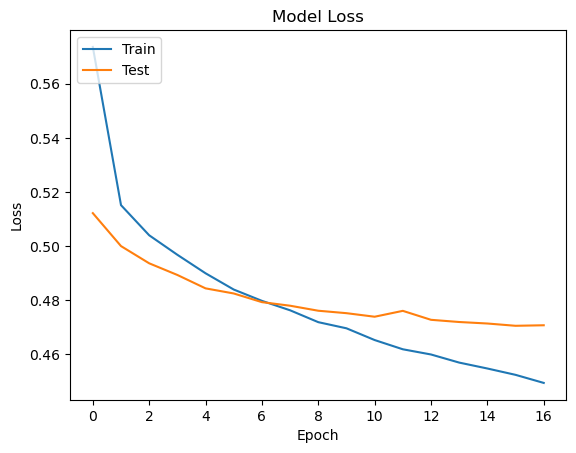

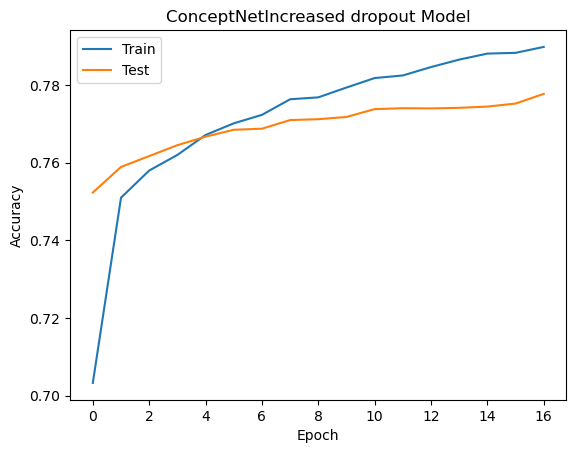

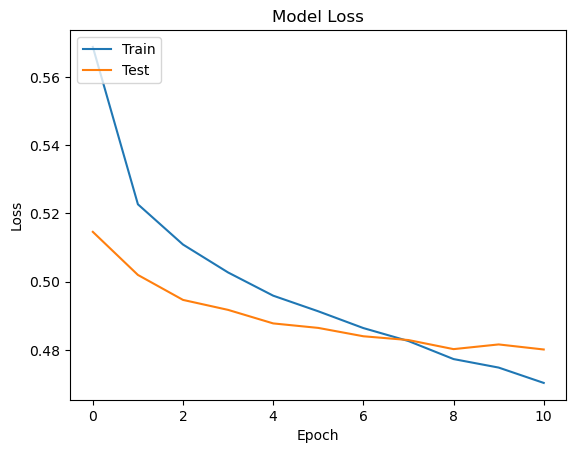

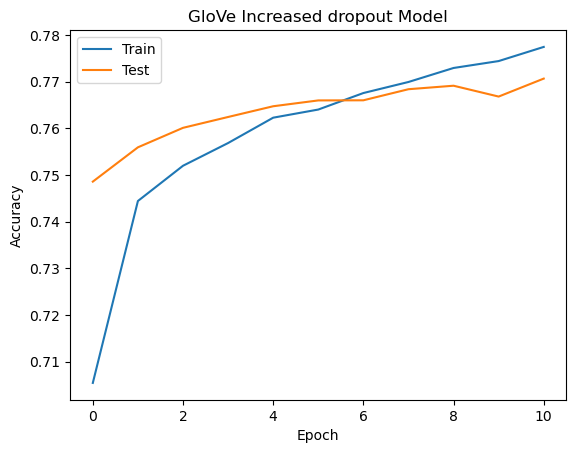

In [77]:
#plot loss and accuracy
def plot_loss_accuracy(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
plot_loss_accuracy(conceptNetModelMoreDropoutHistory, "ConceptNetIncreased dropout Model")
plot_loss_accuracy(gloveModelMoreDropoutHistory, "GloVe Increased dropout Model")

## Reading in Trained Models and Indexer from files and Resume Dataset

In [1]:
#import the dropout models from our files
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [4]:
#import the resumes dataset 
resumes = pd.read_csv("../Data/Resume.csv")

conceptNetModelMoreDropout = load_model("../Data/conceptNetModelMoreDropout.h5")
gloveModelMoreDropout = load_model("../Data/gloveModelMoreDropout.h5")

MAX_ART_LEN = 155

#import the tokenizer..pickle 
if os.path.getsize('../Data/tokenizer.pickle') == 0:
    print("Empty")
with open('../Data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#drop the resume_html column
resumes = resumes.drop(columns=['Resume_html'])

#show value counts for each category
resumes['Category'].value_counts()

engineering_resumes = resumes[resumes['Category'] == 'ENGINEERING']
engineering_resumes.head()


,ID,Resume_str,Category
1690,14206561,ENGINEERING TECHNICIAN High...,ENGINEERING
1691,15139979,ENGINEERING ASSISTANT Summary ...,ENGINEERING
1692,44624796,ENGINEERING MANAGER Profile ...,ENGINEERING
1693,54227873,ENGINEERING INTERN Profession...,ENGINEERING
1694,28005884,ENGINEERING TECHNICIAN Summar...,ENGINEERING


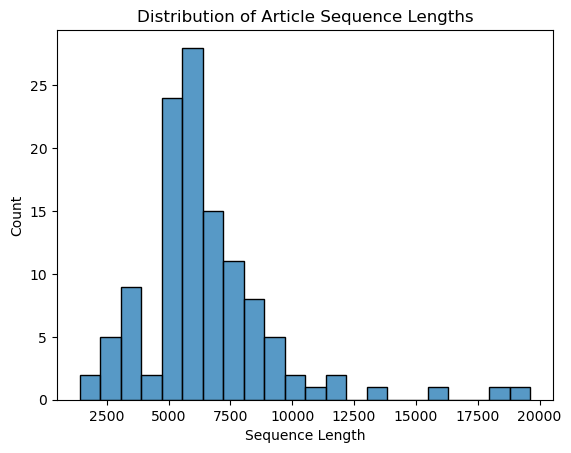

In [5]:
#capture the length of all Resume_str valuees in the engineering_resumes dataframe
sequence_lengths = engineering_resumes['Resume_str'].apply(lambda x: len(x))

sns.histplot(sequence_lengths)

plt.title("Distribution of Article Sequence Lengths")
plt.xlabel("Sequence Length")

plt.show()

## Experiments

We performed 4 experiments in order to preliminarily investigate the differences between GloVe and ConceptNet with respect to Resumes.

## Experiment 1 Testing Masking in All Relevant Resumes from Dataset

This Experiment was done to investigate the effects of removing words of interest from the raw resume test files to see the impact on the predicted sentiment based off of GloVe and ConceptNet. This was done by creating a set of words that we considered significant to each section of bias we are investigating (Gender, Race, Religion, University). The set of words was created using synsets from wordnet. Any resume that included one of these words was added to a subset of the resume dataset. The sentiment was then predicted with both embeddings for the original resume, then was predicted again after any words of interest existing in the resume were masked (replaced with “****”), causing them to no longer be considered in the sentiment prediction. 

In [12]:
import json

gender_json_path = "/Users/ricklattin/Documents/SMU Year 4 Sem 2/Machine Learning and Neural Networks/ML:NN_Final_Project/ML_NN_Final_Proj/masking_words/gender.json"
race_json_path = "/Users/ricklattin/Documents/SMU Year 4 Sem 2/Machine Learning and Neural Networks/ML:NN_Final_Project/ML_NN_Final_Proj/masking_words/race.json"
religion_json_path = "/Users/ricklattin/Documents/SMU Year 4 Sem 2/Machine Learning and Neural Networks/ML:NN_Final_Project/ML_NN_Final_Proj/masking_words/religion.json"

with open(gender_json_path, 'r') as file:
    gender_data = json.load(file)

with open(race_json_path, 'r') as file:
    race_data = json.load(file)

with open(religion_json_path, 'r') as file:
    religion_data = json.load(file)


# for word in gender_data:
#     print(word)

gender_words_to_add = ['man', 'men', 'woman', 'women', 'he', 'him', 'his', 'her', 'hers', 'she', 'mr', 'mrs', 'miss', 'mister', 'missus', 'mistress', 'sir', 'ma\'am', 'madame', 'madam']
gender_data = gender_data+gender_words_to_add

In [13]:
relevant_pdfs_gender = {}
relevant_pdfs_race = {}
relevant_pdfs_religion = {}

for resume_string in resumes["Resume_str"]:

    resume_id = resumes[resumes['Resume_str'] == resume_string]['ID'].reset_index(drop = True)[0]

    # makes all words lowercase
    words = resume_string.split(' ')
    for word_ind in range(len(words)):
        words[word_ind] = words[word_ind].lower()

    for word in words:
        if word in gender_data:
            relevant_pdfs_gender[resume_id] = resume_string

        if word in race_data:
            relevant_pdfs_race[resume_id] = resume_string

        if word in religion_data:
            relevant_pdfs_religion[resume_id] = resume_string

print(f"Gender resumes: {len(relevant_pdfs_gender)}")
print(f"Race resumes: {len(relevant_pdfs_race)}")
print(f"Religion resumes: {len(relevant_pdfs_religion)}")

Gender resumes: 233
Race resumes: 2476
Religion resumes: 2481


In [14]:
unmasked_sentiment_gender_CN = {}
masked_sentiment_gender_CN = {}

unmasked_sentiment_gender_GL = {}
masked_sentiment_gender_GL = {}

for resume_id in relevant_pdfs_gender:
    one_resume = relevant_pdfs_gender[resume_id]

     # unredacted sentiment for the resume
    padded_resume = pad_sequences(tokenizer.texts_to_sequences([one_resume]), maxlen=MAX_ART_LEN)
    resume_sent_pred_CN = conceptNetModelMoreDropout.predict(padded_resume, verbose = 0)
    resume_sent_pred_GL = gloveModelMoreDropout.predict(padded_resume, verbose = 0)

    #saving to dictionary
    unmasked_sentiment_gender_CN[resume_id] = resume_sent_pred_CN
    unmasked_sentiment_gender_GL[resume_id] = resume_sent_pred_GL

    # redacted words related to gender
    words = one_resume.split(' ')
    new_words = []
    for word in words:
        if word in gender_data:
            new_words.append("****")
        else:
            new_words.append(word)
    new_sentence = " ".join(new_words)

    # redacted sentiment for the resume
    padded_resume_redacted= pad_sequences(tokenizer.texts_to_sequences([new_sentence]), maxlen=MAX_ART_LEN)
    resume_sent_pred_redacted_CN = conceptNetModelMoreDropout.predict(padded_resume_redacted, verbose = 0)
    resume_sent_pred_redacted_GL = gloveModelMoreDropout.predict(padded_resume_redacted, verbose = 0)

    # saving to dictionary
    masked_sentiment_gender_CN[resume_id] = resume_sent_pred_redacted_CN
    masked_sentiment_gender_GL[resume_id] = resume_sent_pred_redacted_GL

print(f"Unmasked Sentiment Len for ConceptNet: {len(unmasked_sentiment_gender_CN)}")
print(f"Masked Sentiment Len for ConceptNet: {len(masked_sentiment_gender_CN)}")

print(f"Unmasked Sentiment Len for Glove: {len(unmasked_sentiment_gender_CN)}")
print(f"Masked Sentiment Len for Glove: {len(masked_sentiment_gender_CN)}")

Unmasked Sentiment Len for ConceptNet: 233
Masked Sentiment Len for ConceptNet: 233
Unmasked Sentiment Len for Glove: 233
Masked Sentiment Len for Glove: 233


In [15]:
unmasked_sentiment_race_CN = {}
masked_sentiment_race_CN = {}

unmasked_sentiment_race_GL = {}
masked_sentiment_race_GL = {}

for resume_id in relevant_pdfs_race:
    one_resume = relevant_pdfs_race[resume_id]

     # unredacted sentiment for the resume
    padded_resume = pad_sequences(tokenizer.texts_to_sequences([one_resume]), maxlen=MAX_ART_LEN)
    resume_sent_pred_CN = conceptNetModelMoreDropout.predict(padded_resume, verbose = 0)
    resume_sent_pred_GL = gloveModelMoreDropout.predict(padded_resume, verbose = 0)

    #saving to dictionary
    unmasked_sentiment_race_CN[resume_id] = resume_sent_pred_CN
    unmasked_sentiment_race_GL[resume_id] = resume_sent_pred_GL

    # redacted words related to race
    words = one_resume.split(' ')
    new_words = []
    for word in words:
        if word in race_data:
            new_words.append("****")
        else:
            new_words.append(word)
    new_sentence = " ".join(new_words)

    # redacted sentiment for the resume
    padded_resume_redacted= pad_sequences(tokenizer.texts_to_sequences([new_sentence]), maxlen=MAX_ART_LEN)
    resume_sent_pred_redacted_CN = conceptNetModelMoreDropout.predict(padded_resume_redacted, verbose = 0)
    resume_sent_pred_redacted_GL = gloveModelMoreDropout.predict(padded_resume_redacted, verbose = 0)

    # saving to dictionary
    masked_sentiment_race_CN[resume_id] = resume_sent_pred_redacted_CN
    masked_sentiment_race_GL[resume_id] = resume_sent_pred_redacted_GL

print(f"Unmasked Sentiment Len for ConceptNet: {len(unmasked_sentiment_race_CN)}")
print(f"Masked Sentiment Len for ConceptNet: {len(masked_sentiment_race_CN)}")

print(f"Unmasked Sentiment Len for Glove: {len(unmasked_sentiment_race_CN)}")
print(f"Masked Sentiment Len for Glove: {len(masked_sentiment_race_CN)}")

Unmasked Sentiment Len for ConceptNet: 2476
Masked Sentiment Len for ConceptNet: 2476
Unmasked Sentiment Len for Glove: 2476
Masked Sentiment Len for Glove: 2476


In [16]:
unmasked_sentiment_religion_CN = {}
masked_sentiment_religion_CN = {}

unmasked_sentiment_religion_GL = {}
masked_sentiment_religion_GL = {}

for resume_id in relevant_pdfs_religion:
    one_resume = relevant_pdfs_religion[resume_id]

     # unredacted sentiment for the resume
    padded_resume = pad_sequences(tokenizer.texts_to_sequences([one_resume]), maxlen=MAX_ART_LEN)
    resume_sent_pred_CN = conceptNetModelMoreDropout.predict(padded_resume, verbose = 0)
    resume_sent_pred_GL = gloveModelMoreDropout.predict(padded_resume, verbose = 0)

    #saving to dictionary
    unmasked_sentiment_religion_CN[resume_id] = resume_sent_pred_CN
    unmasked_sentiment_religion_GL[resume_id] = resume_sent_pred_GL

    # redacted words related to religion
    words = one_resume.lower().split(' ')
    new_words = []
    for word in words:
        if word in religion_data:
            new_words.append("****")
        else:
            new_words.append(word)
    new_sentence = " ".join(new_words)

    # redacted sentiment for the resume
    padded_resume_redacted= pad_sequences(tokenizer.texts_to_sequences([new_sentence]), maxlen=MAX_ART_LEN)
    resume_sent_pred_redacted_CN = conceptNetModelMoreDropout.predict(padded_resume_redacted, verbose = 0)
    resume_sent_pred_redacted_GL = gloveModelMoreDropout.predict(padded_resume_redacted, verbose = 0)

    # saving to dictionary
    masked_sentiment_religion_CN[resume_id] = resume_sent_pred_redacted_CN
    masked_sentiment_religion_GL[resume_id] = resume_sent_pred_redacted_GL

print(f"Unmasked Sentiment Len for ConceptNet: {len(unmasked_sentiment_religion_CN)}")
print(f"Masked Sentiment Len for ConceptNet: {len(masked_sentiment_religion_CN)}")

print(f"Unmasked Sentiment Len for Glove: {len(unmasked_sentiment_religion_CN)}")
print(f"Masked Sentiment Len for Glove: {len(masked_sentiment_religion_CN)}")

Unmasked Sentiment Len for ConceptNet: 2481
Masked Sentiment Len for ConceptNet: 2481
Unmasked Sentiment Len for Glove: 2481
Masked Sentiment Len for Glove: 2481


In [17]:
import pandas as pd

columns = ["Type of Bias", "Embedding", "File ID", "Unmasked Sentiment", "Masked Sentiment"]

df = pd.DataFrame(columns = columns)

# populate dataframe for gender
for resume_item in unmasked_sentiment_gender_CN:
    df = pd.concat([df, 
        pd.DataFrame({"Type of Bias": "Gender", "Embedding": "ConceptNet", "File ID": [resume_item], "Unmasked Sentiment":[unmasked_sentiment_gender_CN[resume_item][0][0]], "Masked Sentiment":[masked_sentiment_gender_CN[resume_item][0][0]]}),
        pd.DataFrame({"Type of Bias": "Gender", "Embedding": "Glove", "File ID": [resume_item], "Unmasked Sentiment": [unmasked_sentiment_gender_GL[resume_item][0][0]], "Masked Sentiment":[masked_sentiment_gender_GL[resume_item][0][0]]}),
        ])

# populate dataframe for race
for resume_item in unmasked_sentiment_race_CN:
    df = pd.concat([df, 
        pd.DataFrame({"Type of Bias": "Race", "Embedding": "ConceptNet", "File ID": [resume_item], "Unmasked Sentiment":[unmasked_sentiment_race_CN[resume_item][0][0]], "Masked Sentiment":[masked_sentiment_race_CN[resume_item][0][0]]}),
        pd.DataFrame({"Type of Bias": "Race", "Embedding": "Glove", "File ID": [resume_item], "Unmasked Sentiment": [unmasked_sentiment_race_GL[resume_item][0][0]], "Masked Sentiment":[masked_sentiment_race_GL[resume_item][0][0]]}),
        ])

# populate dataframe for religion
for resume_item in unmasked_sentiment_religion_CN:
    df = pd.concat([df, 
        pd.DataFrame({"Type of Bias": "Religion", "Embedding": "ConceptNet", "File ID": [resume_item], "Unmasked Sentiment":[unmasked_sentiment_religion_CN[resume_item][0][0]], "Masked Sentiment":[masked_sentiment_religion_CN[resume_item][0][0]]}),
        pd.DataFrame({"Type of Bias": "Religion", "Embedding": "Glove", "File ID": [resume_item], "Unmasked Sentiment": [unmasked_sentiment_religion_GL[resume_item][0][0]], "Masked Sentiment":[masked_sentiment_religion_GL[resume_item][0][0]]}),
        ])

df["Sentiment Difference"] = df["Masked Sentiment"]-df["Unmasked Sentiment"]

# print(df["Masked Sentiment"])

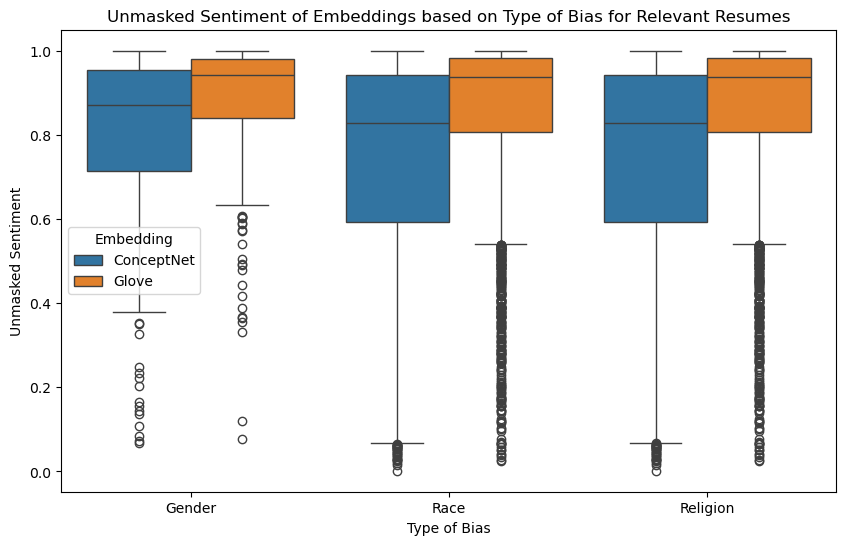

In [25]:
plt.figure(figsize = (10, 6))
sns.boxplot(df, x="Type of Bias", y="Unmasked Sentiment", hue="Embedding")
plt.title("Unmasked Sentiment of Embeddings based on Type of Bias for Relevant Resumes")
plt.show()

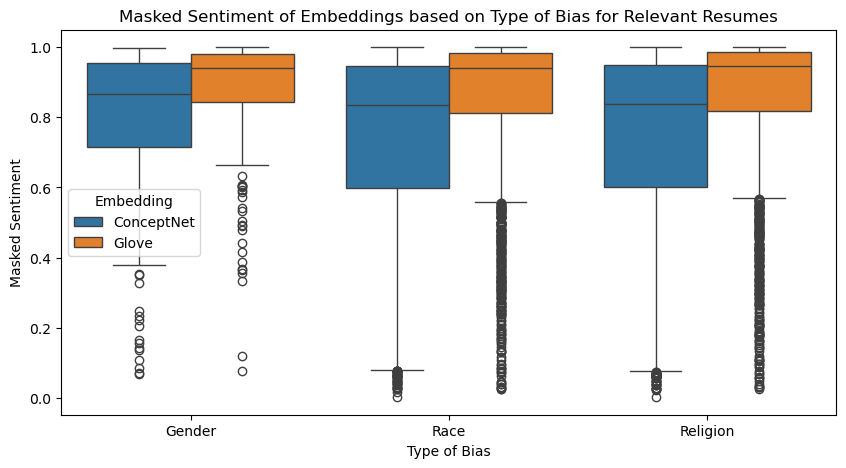

In [24]:
plt.figure(figsize = (10, 5))
sns.boxplot(df, x="Type of Bias", y="Masked Sentiment", hue="Embedding")
plt.title("Masked Sentiment of Embeddings based on Type of Bias for Relevant Resumes")
plt.show()

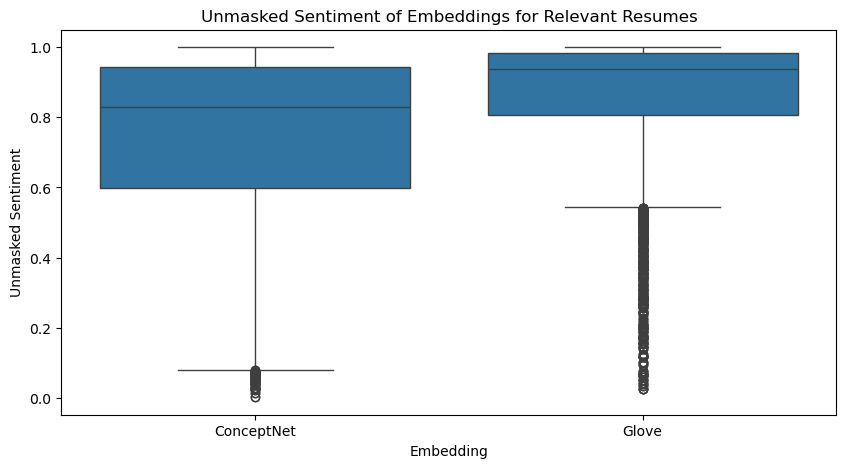

In [26]:
plt.figure(figsize = (10, 5))
sns.boxplot(df, x="Embedding", y="Unmasked Sentiment")
plt.title("Unmasked Sentiment of Embeddings for Relevant Resumes")
plt.show()

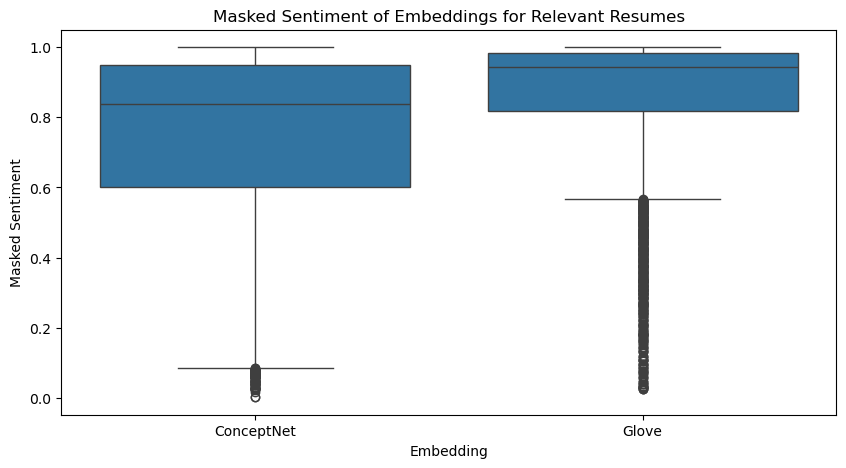

In [27]:
plt.figure(figsize = (10, 5))
sns.boxplot(df, x="Embedding", y="Masked Sentiment")
plt.title("Masked Sentiment of Embeddings for Relevant Resumes")
plt.show()

From this experiment it is very hard to show obvious differences of masking this data and leaving it unmasked. From the information we see here, conceptNet seems to be more evenly distributed than Glove. **We plan on making a difference plot where we analyze the difference between masked an unmasked sentences to see if more visually aparent data is shown**, as it stands no substantial claims can be made here from just this experiment which is why we want to do a deeper dive into race and education below. 

## Experiment 2 Breakdown of impact of Ethnic Names on Resume Sentiment



This next experiment was done to investigate specifically how the two embedding perceive ethnicities based on the sentiment of names that are historically based from different ethnic groups. This was done by taking a single sentence that we determined to be of neutral sentiment and was pulled from one of the resumes, and comparing this sentence with the names of different ethnicities. These newly formed sentences are then run through both GloVe and ConceptNet to get the predicted sentiments when influenced by individual names. The difference between the baseline and the newly predicted sentences were then recorded. This experiment was done with a baseline sentence, where the name is simply appended to the beginning of a full sentence, and again with a sentence where the name is added to the sentence in a way that makes semantical sense. 

### Testing general sentiment scores of resumes in resume dataset

In [21]:
beginner_resume_exerpt_raw = 'I have over 29 years of progressive experience in the electrical, communications, electronics, and telecommunications fields.'

#I would like to run my beginner resume exerpt through the ConceptNet Model to predict its sentiment
beginner_resume_exerpt = pad_sequences(tokenizer.texts_to_sequences([beginner_resume_exerpt_raw]), maxlen=MAX_ART_LEN)
resume_sent_pred = conceptNetModelMoreDropout.predict(beginner_resume_exerpt, verbose=0)
print(resume_sent_pred)

resume_sent_pred_GL = gloveModelMoreDropout.predict(beginner_resume_exerpt, verbose=0)
print(resume_sent_pred_GL)

#sentiment_pred = model.predict(X_test)[:,0]

larger_exerpt = 'Performed the installation and upgrade of USCG HF sites and in various locations which included the Greater Antilles Section(GANTSEC) Performed HF Fan Wire Impedance Matching on U.S. Navy ships. Assisted in the installation of the Appleton, WA prototype Ground Wave Electrical Network (GWEN) conversion to DGPS and has performed a number of other NDGPS conversions. Served as team leader on the installation of the PA-Alarm Systems on USCG WLIC Boats. Performed the equipment installations and system upgrades for the Vessel Traffic Control Systems (VTC) in numerous locations including Houston/Galveston, TX area. Performed installation and set-up of National Distress System (NDS) equipment in various locations including North Carolina and Florida.'

print("larger exerpt length: ", len(larger_exerpt))

larger_exerpt = pad_sequences(tokenizer.texts_to_sequences([larger_exerpt]), maxlen=MAX_ART_LEN)
resume_sent_pred = conceptNetModelMoreDropout.predict(larger_exerpt)
print(resume_sent_pred)

#find the engineering resume ID with the longest sequence length
largest_resume_id = engineering_resumes['Resume_str'].apply(lambda x: len(x)).idxmax()
largest_resume = engineering_resumes.loc[largest_resume_id]['Resume_str']
print("largest resume length: ", len(largest_resume))

#run the largest resume through the model
largest_resume = pad_sequences(tokenizer.texts_to_sequences([largest_resume]), maxlen=MAX_ART_LEN)
lrg_resume_sent_pred = conceptNetModelMoreDropout.predict(largest_resume)
print(lrg_resume_sent_pred)


[[0.65169555]]
[[0.5805068]]
larger exerpt length:  751
1/1 [==============================] - 0s 14ms/step
[[0.44378105]]
largest resume length:  19632
1/1 [==============================] - 0s 12ms/step
[[0.8386169]]


In [22]:
mexican_name = 'Alonzo'
white_name = 'Adam'

modified_exerpt_1_raw = beginner_resume_exerpt_raw + ' ' + mexican_name
modified_exerpt_2_raw = beginner_resume_exerpt_raw + ' ' + white_name

modified_exerpt_2 = pad_sequences(tokenizer.texts_to_sequences([modified_exerpt_2_raw]), maxlen=MAX_ART_LEN)
modified_exerpt_sent = conceptNetModelMoreDropout.predict(modified_exerpt_2, verbose=0)
modified_exerpt_sent_GL = gloveModelMoreDropout.predict(modified_exerpt_2, verbose=0)
print('CN sent Adam', modified_exerpt_sent)
print('GL sent Adam', modified_exerpt_sent_GL)

mexican_name2 = 'Jamel'
white_name2 = 'Chip'
modified_exerpt_3_raw = beginner_resume_exerpt_raw + ' ' + mexican_name2
modified_exerpt_4_raw = beginner_resume_exerpt_raw + ' ' + white_name2

modified_exerpt_4 = pad_sequences(tokenizer.texts_to_sequences([modified_exerpt_4_raw]), maxlen=MAX_ART_LEN)
modified_exerpt_sent2 = conceptNetModelMoreDropout.predict(modified_exerpt_4, verbose=0)
modified_exerpt_sent_GL2 = gloveModelMoreDropout.predict(modified_exerpt_4, verbose=0)
print('CN sent Chip', modified_exerpt_sent2)
print('GL sent Chip', modified_exerpt_sent_GL2)




CN sent Adam [[0.5921909]]
GL sent Adam [[0.58563673]]
CN sent Chip [[0.5921909]]
GL sent Chip [[0.58563673]]


In [8]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Ellen', 'Lauren', 'Peggy', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Torrance', 'Darnell', 'Lamar', 'Lionel',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 
        'Lavon', 'Marcellus', 'Wardell', 'Nichelle',
        'Ebony', 'Shaniqua', 
        'Jasmine', 'Tanisha', 'Tia', 'Latoya',
        'Yolanda', 'Malika', 'Yvette'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Jorge', 'Santiago',
        'Mateo',  'Alejandro', 'Samuel', 'Diego', 'Daniel', 
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    #Larson Edit: had to remove a number of names that were not in the embedding
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Syed', 'Samar', 'Ahmad', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

sentiment_difference_df = pd.DataFrame(columns=['Name', 'Ethnicity', 'ConceptNet_sentiment', 'GloVe_sentiment', 'Sentiment_Difference_ConceptNet', 'Sentiment_Difference_GloVe'])
                
for ethnicity, names in NAMES_BY_ETHNICITY.items():
    for name in names:
        modified_exerpt_raw = beginner_resume_exerpt_raw + ' ' + name
        
        modified_exerpt_CN = pad_sequences(tokenizer.texts_to_sequences([modified_exerpt_raw]), maxlen=MAX_ART_LEN)
        modified_exerpt_GL = pad_sequences(tokenizer.texts_to_sequences([modified_exerpt_raw]), maxlen=MAX_ART_LEN)
        
        modified_sent_pred_CN = conceptNetModelMoreDropout.predict(modified_exerpt_CN, verbose=0)
        modified_sent_pred_GL = gloveModelMoreDropout.predict(modified_exerpt_GL, verbose=0)
        
        sentiment_dif_CN = modified_sent_pred_CN - resume_sent_pred
        sentiment_dif_GL = modified_sent_pred_GL - resume_sent_pred_GL
        
        race_analysis = pd.DataFrame({
            'Name': [name],
            'Ethnicity' : [ethnicity],
            'ConceptNet_sentiment': [modified_sent_pred_CN[0][0]],
            'GloVe_sentiment': [modified_sent_pred_GL[0][0]],
            'Sentiment_Difference_ConceptNet': [sentiment_dif_CN[0][0]],
            'Sentiment_Difference_GloVe': [sentiment_dif_GL[0][0]]
        })
        
        sentiment_difference_df = pd.concat([sentiment_difference_df, race_analysis], ignore_index=True)
        
        # pd.concat([sentiment_difference_df, pd.DataFrame({
        #     'Name': name,
        #     'Ethnicity' : ethnicity,
        #     'ConceptNet_sentiment': modified_sent_pred_CN[0][0],
        #     'GloVe_sentiment': modified_sent_pred_GL[0][0],
        #     'Sentiment_Difference_ConceptNet': sentiment_dif_CN[0][0],
        #     'Sentiment_Difference_GloVe': sentiment_dif_GL[0][0]
        # })], ignore_index=True)
        
        # sentiment_difference_df = sentiment_difference_df.append({
        #     'Name': name,
        #     'Ethnicity' : ethnicity,
        #     'ConceptNet_sentiment': modified_sent_pred_CN[0][0],
        #     'GloVe_sentiment': modified_sent_pred_GL[0][0],
        #     'Sentiment_Difference_ConceptNet': sentiment_dif_CN[0][0],
        #     'Sentiment_Difference_GloVe': sentiment_dif_GL[0][0]
        # }, ignore_index=True)
        
print(sentiment_difference_df)
        



        Name    Ethnicity  ConceptNet_sentiment  GloVe_sentiment  \
0       Adam        White              0.592191         0.585637   
1       Chip        White              0.592191         0.585637   
2      Harry        White              0.592191         0.585637   
3       Josh        White              0.592191         0.585637   
4      Roger        White              0.592191         0.585637   
..       ...          ...                   ...              ...   
123     Zara  Arab/Muslim              0.592191         0.585637   
124     Alya  Arab/Muslim              0.651696         0.580507   
125  Shaista  Arab/Muslim              0.651696         0.580507   
126     Zoya  Arab/Muslim              0.651696         0.580507   
127   Yasmin  Arab/Muslim              0.592191         0.585637   

     Sentiment_Difference_ConceptNet  Sentiment_Difference_GloVe  
0                          -0.059505                     0.00513  
1                          -0.059505             

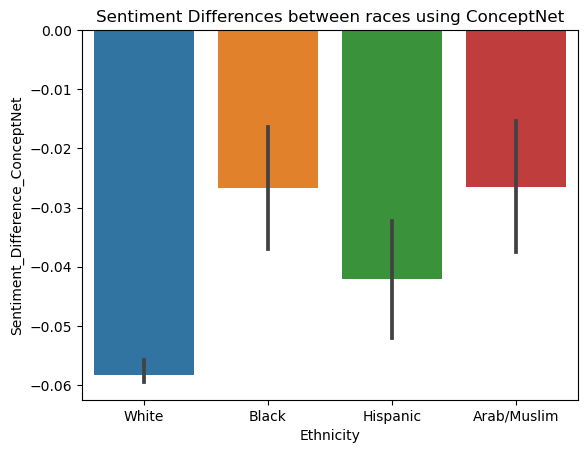

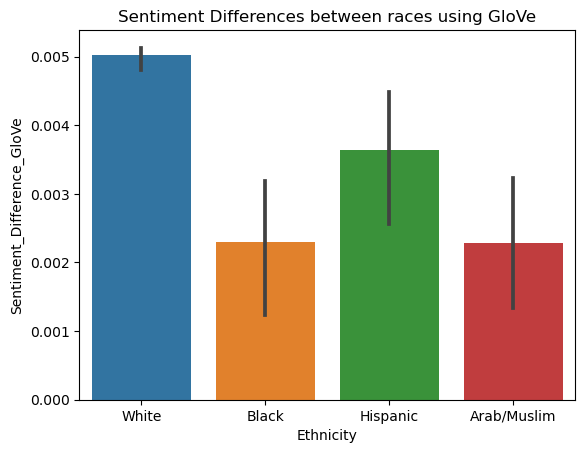

In [9]:
#plot the differences of each ethnicity in the sentiment_difference_df
sns.barplot(data=sentiment_difference_df, x='Ethnicity', y='Sentiment_Difference_ConceptNet')
plt.title("Sentiment Differences between races using ConceptNet")
plt.show()

sns.barplot(data=sentiment_difference_df, x='Ethnicity', y='Sentiment_Difference_GloVe')
plt.title("Sentiment Differences between races using GloVe")
plt.show()



In [13]:
#run the test again by use the new beginner resume exerpt and have the name be at the beggining of the string
  
#changing the context of the sentence to have it be more realistic in a resume you'd see
beginner_resume_exerpt_raw = ' has over 29 years of progressive experience in the electrical, communications, electronics, and telecommunications fields.'
test_name = 'Alejandro'
#adding test_name to beginning of string
modified_race_exert = test_name + beginner_resume_exerpt_raw
print(modified_race_exert)

#add "with context" columns to the dataframe
sentiment_difference_df['CN_sent_wc'] = 0
sentiment_difference_df['GL_sent_wc'] = 0
sentiment_difference_df['CN_dif_wc'] = 0
sentiment_difference_df['GL_dif_wc'] = 0
                 
for ethnicity, names in NAMES_BY_ETHNICITY.items():
    for name in names:
        modified_exerpt_raw = name + beginner_resume_exerpt_raw 
        
        modified_exerpt_CN = pad_sequences(tokenizer.texts_to_sequences([modified_exerpt_raw]), maxlen=MAX_ART_LEN)
        modified_exerpt_GL = pad_sequences(tokenizer.texts_to_sequences([modified_exerpt_raw]), maxlen=MAX_ART_LEN)
        
        modified_sent_pred_CN = conceptNetModelMoreDropout.predict(modified_exerpt_CN, verbose=0)
        modified_sent_pred_GL = gloveModelMoreDropout.predict(modified_exerpt_GL, verbose=0)
        
        sentiment_dif_CN = modified_sent_pred_CN - resume_sent_pred
        sentiment_dif_GL = modified_sent_pred_GL - resume_sent_pred_GL
        
        # Find the row with the corresponding name and ethnicity
        mask = (sentiment_difference_df['Name'] == name) & (sentiment_difference_df['Ethnicity'] == ethnicity)
        
        # Update the values for the existing row
        sentiment_difference_df.loc[mask, 'CN_sent_wc'] = modified_sent_pred_CN[0][0]
        sentiment_difference_df.loc[mask, 'GL_sent_wc'] = modified_sent_pred_GL[0][0]
        sentiment_difference_df.loc[mask, 'CN_dif_wc'] = sentiment_dif_CN[0][0]
        sentiment_difference_df.loc[mask, 'GL_dif_wc'] = sentiment_dif_GL[0][0]
        
        # race_analysis_with_context = pd.DataFrame({
        #     'CN_sent_wc': [modified_sent_pred_CN[0][0]],
        #     'GL_sent_wc': [modified_sent_pred_GL[0][0]],
        #     'CN_dif_wc': [sentiment_dif_CN[0][0]],
        #     'GL_dif_wc': [sentiment_dif_GL[0][0]]
        # })
        
        # sentiment_difference_df = pd.concat([sentiment_difference_df, race_analysis_with_context], ignore_index=True)
        

Alejandro has over 29 years of progressive experience in the electrical, communications, electronics, and telecommunications fields.


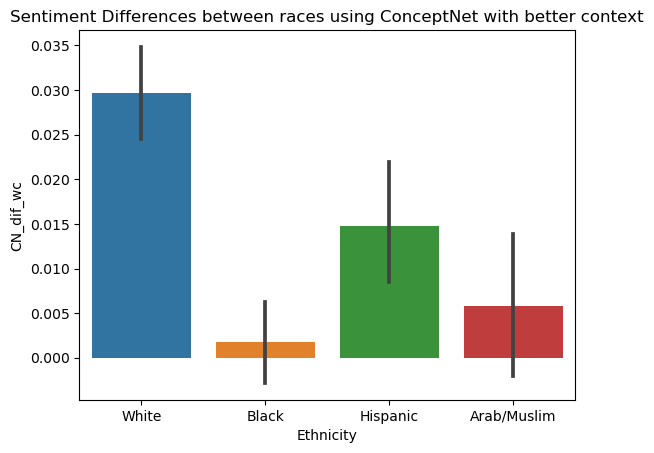

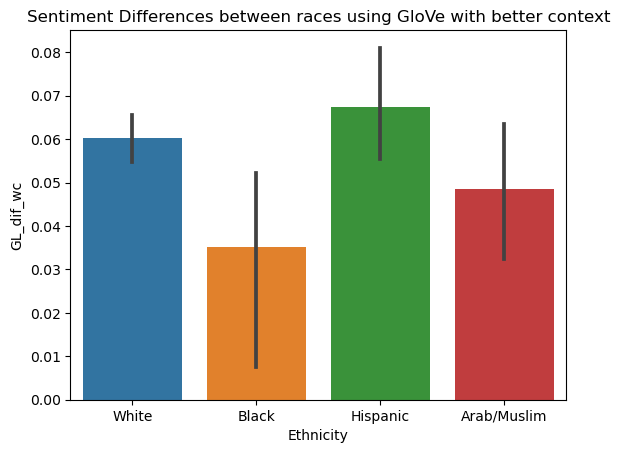

In [12]:
sns.barplot(data=sentiment_difference_df, x='Ethnicity', y='CN_dif_wc')
plt.title("Sentiment Differences between races using ConceptNet with better context")
plt.show()

sns.barplot(data=sentiment_difference_df, x='Ethnicity', y='GL_dif_wc')
plt.title("Sentiment Differences between races using GloVe with better context")
plt.show()

We see here that context aids the sentiment of ConceptNet by now having increases in sentiment rather than decreases. Glove with no context adds extremely little positive sentiment with a name, but in a sentence with better thematic structure, this sentiment score is boosted to a much greater degree. ConceptNet only has a 0.03 increase to its largest category of White names while every category in Glove has an increase greater than 0.03. In the 4 graphs, only the Glove with context graph was White not the largest increase or decrease in sentiment. Glove with context, in our hispanic name testing had the largest increase to sentiment, where in the other 3 experiments, White names had the largest jump.

## Experiment 3 Testing sentiment changes via University Type

In this third experiment we want to see if Educational instituions have an impact on bias given a resume context. In this experiment, very similary to the experiment above we have chosen 4 different categories of Universities: Ivy league, Prominent Public Universities, Private Universities, and International Universities. We are from the United States so "International" is meaning schools outside the US. These will be measured against a resume exerpt we found from the resume dataset and we will add in with context what University they attended to see if it has an impact on sentiment. 

In [14]:
UNIVERSITIES_BY_TYPE = {
    'Ivy League': [
        'Harvard University',
        'Yale University',
        'Princeton University',
        'Columbia University',
        'University of Pennsylvania',
        'Brown University',
        'Dartmouth College',
        'Cornell University'
    ],
    'Prominent Public Universities': [
        'University of California, Berkeley',
        'University of Michigan',
        'University of California, Los Angeles (UCLA)',
        'University of Virginia',
        'University of North Carolina at Chapel Hill',
        'University of California, San Diego (UCSD)',
        'University of Illinois at Urbana-Champaign',
        'University of Texas at Austin'
    ],
    'Private Universities': [
        'Stanford University',
        'Massachusetts Institute of Technology',
        'California Institute of Technology',
        'Southern Methodist University',
        'Johns Hopkins University',
        'Northwestern University',
        'Duke University',
        'Vanderbilt University'
    ],
    'Famous International Universities': [
        'University of Oxford',
        'University of Cambridge',
        'ETH Zurich - Swiss Federal Institute of Technology',
        'University College London (UCL)',
        'Imperial College London',
        'National University of Singapore (NUS)',
        'University of Toronto',
        'University of Tokyo'
    ]
}

In [15]:
ivy_league_uni = 'Harvard University'
public_uni = 'University of California, Berkeley'
private_uni = 'Stanford University'
international_uni = 'University of Oxford'

sent_ivy_gl = gloveModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([ivy_league_uni]), maxlen=MAX_ART_LEN), verbose=0)
sent_pub_gl = gloveModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([public_uni]), maxlen=MAX_ART_LEN), verbose=0)
sent_priv_gl = gloveModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([private_uni]), maxlen=MAX_ART_LEN), verbose=0)
sent_int_gl = gloveModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([international_uni]), maxlen=MAX_ART_LEN), verbose=0)

print('Ivy League:', sent_ivy_gl)
print('Public:', sent_pub_gl)
print('Private:', sent_priv_gl)
print('International:', sent_int_gl)

univ_exerpt = "Driven and a self-motivated Mechanical Engineer with experience teaching Mechanical Engineering courses to undergraduate students. Seeking opportunities to use those concepts in the field of Construction and Management "
sent_univ_gl = gloveModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([univ_exerpt]), maxlen=MAX_ART_LEN), verbose=0)
sent_univ_cn = conceptNetModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([univ_exerpt]), maxlen=MAX_ART_LEN), verbose=0)
print("univ example sent GloVe: ", sent_univ_gl, "univ example sent ConceptNet: ", sent_univ_cn)


uni_sent_dif_df = pd.DataFrame(columns=['University', 'Type', 'GloVe_sentiment', 'ConceptNet_sentiment', 'Sentiment_Difference_GloVe', 'Sentiment_Difference_ConceptNet'])
uni = 'Stanford'

test= 'Attends '+ uni + '. ' + univ_exerpt
print(test)

Ivy League: [[0.54179955]]
Public: [[0.5152091]]
Private: [[0.47929043]]
International: [[0.5111351]]
univ example sent GloVe:  [[0.86331517]] univ example sent ConceptNet:  [[0.83442134]]
Attends Stanford. Driven and a self-motivated Mechanical Engineer with experience teaching Mechanical Engineering courses to undergraduate students. Seeking opportunities to use those concepts in the field of Construction and Management 


In [16]:
univ_exerpt = "Driven and a self-motivated Mechanical Engineer with experience teaching Mechanical Engineering courses to undergraduate students. Seeking opportunities to use those concepts in the field of Construction and Management."
univ_exerpt_base_sent_gl = gloveModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([univ_exerpt]), maxlen=MAX_ART_LEN), verbose=0)
univ_exerpt_base_sent_cn = conceptNetModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([univ_exerpt]), maxlen=MAX_ART_LEN), verbose=0)

uni_sent_dif_df = pd.DataFrame(columns=['University', 'Type', 'GloVe_sentiment', 'ConceptNet_sentiment', 'Sentiment_Difference_GloVe', 'Sentiment_Difference_ConceptNet', 'Se'])

#loop through every university in the UNIVERSITY BY TYPE dictionary
for uni_type, unis in UNIVERSITIES_BY_TYPE.items():
    for uni in unis:
        uni_exerpt = 'Attends '+ uni + '. ' + univ_exerpt
        uni_sent_gl = gloveModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([uni_exerpt]), maxlen=MAX_ART_LEN), verbose=0)
        uni_sent_cn = conceptNetModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([uni_exerpt]), maxlen=MAX_ART_LEN), verbose=0)
        
        
        
        uni_sent_dif_gl = uni_sent_gl - univ_exerpt_base_sent_gl
        uni_sent_dif_cn = uni_sent_cn - univ_exerpt_base_sent_cn
        
        uni_analysis = pd.DataFrame({
            'University': [uni],
            'Type': [uni_type],
            'GloVe_sentiment': [uni_sent_gl[0][0]],
            'ConceptNet_sentiment': [uni_sent_cn[0][0]],
            'Sentiment_Difference_GloVe': [uni_sent_dif_gl[0][0]],
            'Sentiment_Difference_ConceptNet': [uni_sent_dif_cn[0][0]]
        })
        
        uni_sent_dif_df = pd.concat([uni_sent_dif_df, uni_analysis], ignore_index=True)

#print(uni_sent_dif_df)

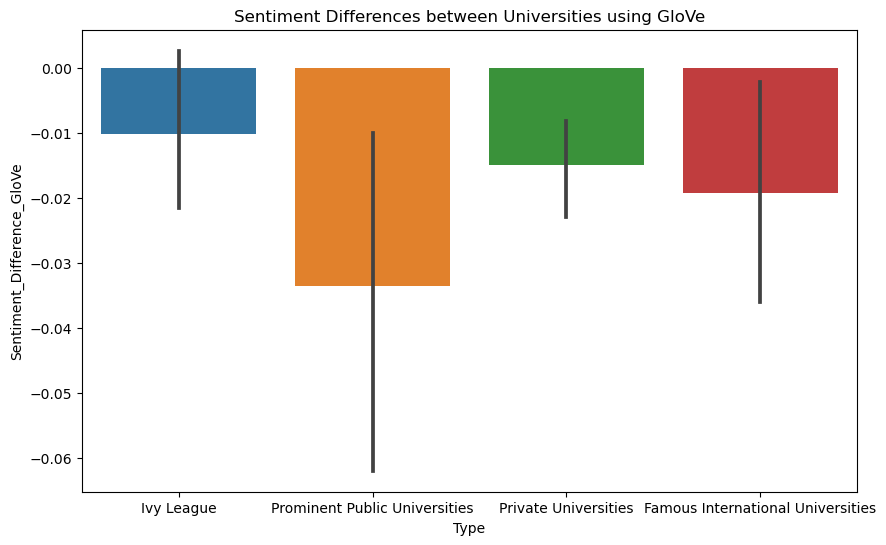

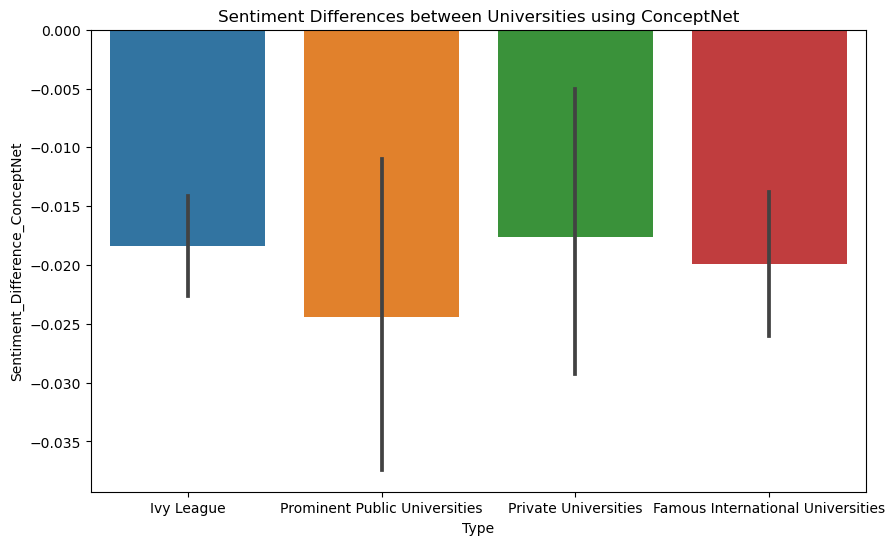

In [17]:
#plot the difference in sentiment by university type 
plt.figure(figsize=(10,6))
sns.barplot(data=uni_sent_dif_df, x='Type', y='Sentiment_Difference_GloVe')
plt.title("Sentiment Differences between Universities using GloVe")
plt.show()


plt.figure(figsize = (10,6))
sns.barplot(data=uni_sent_dif_df, x='Type', y='Sentiment_Difference_ConceptNet')
plt.title("Sentiment Differences between Universities using ConceptNet")
plt.show()


These results show that for both ConceptNet and GloVe, that there is a negative impact on sentiment and that Public Universities change this sentiment the most. Public Universities also have the highest degree of variance. Every Resume will have a university name on it, so this could be a limitation of the tweets dataset that we trained our model on. (when people tweet about a school by name it is most likely not positive). ConceptNet was more equal across the 4 categories.

## Experiment 4 Comparing University and Ethnicity by Name

The final experiment was a comparison of both the names and the universities paired together. In this experiment sentiment predictions were recorded in a similar way to both the individual ethnicity by names experiment and universities experiment. A sample sentence was taken from a resume that was used to incorporate both the names of various universities and the names associated with various ethnicities. The sentiment prediction of the baseline sentence was then compared to the sentiment predictions when a given name and university were incorporated into the sentence. The differences were then recorded and plotted.

In [16]:
columns = ['Entry ID', 'University Type', 'Ethnicity of Name', 'ConceptNet Sentiment', 'Glove Sentiment', 'CN Difference from Baseline', 'GL Difference from Baseline']
university_ethnicity_comparisons_df = pd.DataFrame(columns=columns)

index = 0
base_sentence = " is an Engineering Technician with an extensive troubleshooting, repair, and installation background. Thorough knowledge of Electrical, Mechanical, Pneumatic and computer systems. Self-starter who quickly masters new skills and systems. Attends "

base_univ_exerpt = "Engineering Technician with an extensive troubleshooting, repair, and installation background. Thorough knowledge of Electrical, Mechanical, Pneumatic and computer systems. Self-starter who quickly masters new skills and systems."
base_sent_univ_gl = gloveModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([base_univ_exerpt]), maxlen=MAX_ART_LEN), verbose=0)
base_sent_univ_cn = conceptNetModelMoreDropout.predict(pad_sequences(tokenizer.texts_to_sequences([base_univ_exerpt]), maxlen=MAX_ART_LEN), verbose=0)

# get every university univeristy type
for university_type in UNIVERSITIES_BY_TYPE:

    # get every ethnicity of name to compare to give university
    for ethnicity in NAMES_BY_ETHNICITY:

        # compare every possible pair of names from the groups to each other
        for university in university_type:
            for name in ethnicity:
                comparison_sentence = f"{name}{base_sentence}{university}."

                # predicts sentiment of comparison
                comparison_sentence = pad_sequences(tokenizer.texts_to_sequences([comparison_sentence]), maxlen=MAX_ART_LEN)
                comparison_sent_pred_CN = conceptNetModelMoreDropout.predict(comparison_sentence, verbose = 0)
                comparison_sent_pred_GL = gloveModelMoreDropout.predict(comparison_sentence, verbose=0)

                comparison_entry = pd.DataFrame({'Entry ID':[index], 
                                                 'University Type':[university_type], 
                                                 'Ethnicity of Name':[ethnicity], 
                                                 'ConceptNet Sentiment':[comparison_sent_pred_CN[0][0]], 
                                                 'Glove Sentiment':[comparison_sent_pred_GL[0][0]],
                                                 'CN Difference from Baseline':[base_sent_univ_cn[0][0] - comparison_sent_pred_CN[0][0]],
                                                 'GL Difference from Baseline':[base_sent_univ_gl[0][0] - comparison_sent_pred_GL[0][0]]})
                university_ethnicity_comparisons_df = pd.concat([university_ethnicity_comparisons_df, comparison_entry], ignore_index = False)

                index = index+1

university_ethnicity_comparisons_df        

,Entry ID,University Type,Ethnicity of Name,ConceptNet Sentiment,Glove Sentiment,CN Difference from Baseline,GL Difference from Baseline
0,0,Ivy League,White,0.953242,0.950373,-0.002524,-0.011223
0,1,Ivy League,White,0.952140,0.948665,-0.001422,-0.009515
0,2,Ivy League,White,0.947127,0.954674,0.003591,-0.015524
0,3,Ivy League,White,0.936115,0.948339,0.014603,-0.009189
0,4,Ivy League,White,0.948828,0.952978,0.001890,-0.013828
...,...,...,...,...,...,...,...
0,2663,Famous International Universities,Arab/Muslim,0.956477,0.962262,-0.005759,-0.023112
0,2664,Famous International Universities,Arab/Muslim,0.949201,0.953432,0.001516,-0.014282
0,2665,Famous International Universities,Arab/Muslim,0.949752,0.955476,0.000966,-0.016326
0,2666,Famous International Universities,Arab/Muslim,0.947127,0.954674,0.003591,-0.015524


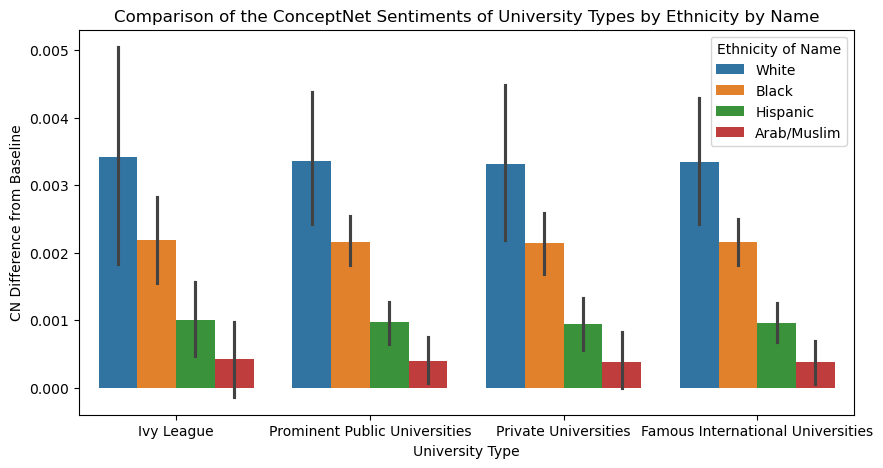

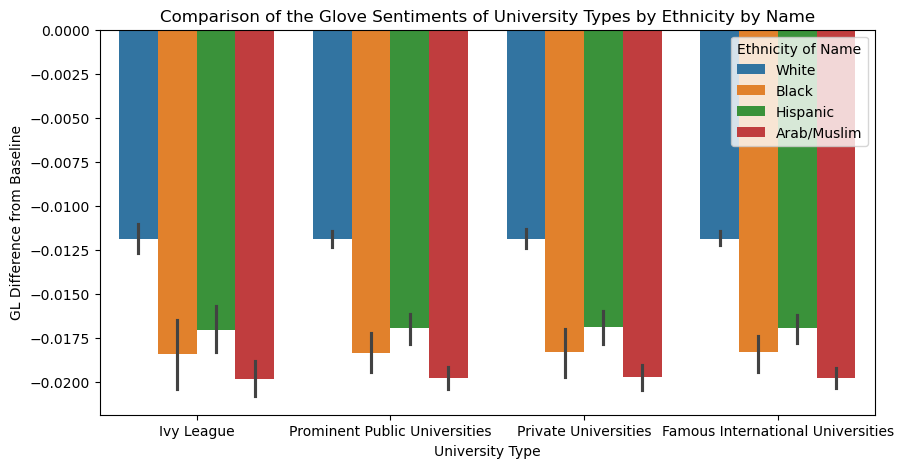

In [17]:
plt.figure(figsize = (10, 5))
sns.barplot(data=sentiment_difference_df, 
            x=university_ethnicity_comparisons_df['University Type'], 
            y=university_ethnicity_comparisons_df['CN Difference from Baseline'], 
            hue=university_ethnicity_comparisons_df['Ethnicity of Name'])
plt.title("Comparison of the ConceptNet Sentiments of University Types by Ethnicity by Name")
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(data=sentiment_difference_df, 
            x=university_ethnicity_comparisons_df['University Type'], 
            y=university_ethnicity_comparisons_df['GL Difference from Baseline'], 
            hue=university_ethnicity_comparisons_df['Ethnicity of Name'])
plt.title("Comparison of the Glove Sentiments of University Types by Ethnicity by Name")
plt.show()

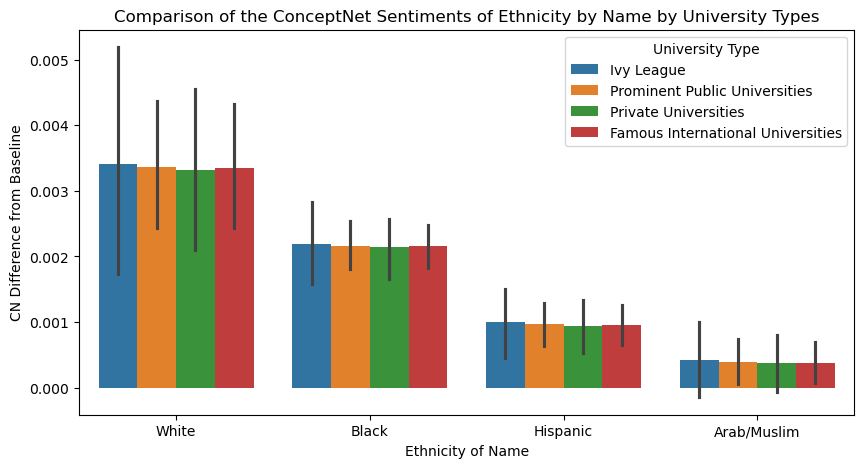

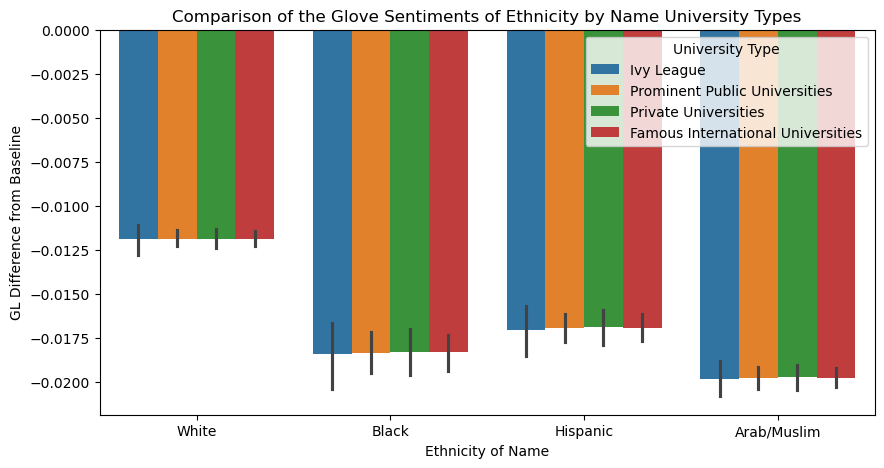

In [18]:
plt.figure(figsize = (10, 5))
sns.barplot(data=sentiment_difference_df, 
            x=university_ethnicity_comparisons_df['Ethnicity of Name'], 
            y=university_ethnicity_comparisons_df['CN Difference from Baseline'], 
            hue=university_ethnicity_comparisons_df['University Type'])
plt.title("Comparison of the ConceptNet Sentiments of Ethnicity by Name by University Types")
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(data=sentiment_difference_df, 
            x=university_ethnicity_comparisons_df['Ethnicity of Name'], 
            y=university_ethnicity_comparisons_df['GL Difference from Baseline'], 
            hue=university_ethnicity_comparisons_df['University Type'])
plt.title("Comparison of the Glove Sentiments of Ethnicity by Name University Types")
plt.show()

When names and universities are added together, thankfully the educational institution type doesnt have an influence on sentiment, but names do have a substantial change where interestingly, in both embeddings White names have more positive sentiment change than the other races across the different educational types. 

## Limitations of our experiment


Despite the benefits, there are a few limitations to the experiments we conducted in this paper. The primary limitation is that the CNN’s we created were trained off of a sentiment analysis dataset that is composed solely of tweets. This does not invalidate any of the experiments we have done but it does make them less generalizable, as the CNN’s do not have as much of an objective source of sentiment analysis that we would ideally like to implement. The text of twitter is very different from the text seen in our resume dataset, therefore it is possible that our models have limitations when addressing formal text such as the resumes we are using it with. All of the experiments we are doing are focusing on self contained comparisons, so they should still be giving good data, but the distinction in training and testing datasets should be noted.

Furthermore, although we were inspired by the idea that aspects of a resume can have a large impact on whether or not a machine learning resume model flags it, we are by no means testing that within these experiments. We are not implementing any dataset involving the results/hireability of the resumes during the training of any of the models, and the sentiment does not necessarily reflect anything in that realm as well. Due to the scarcity of data on this matter any correlation between these would be hard to test in terms of ML models. 

We use around 100,000 tweets to train our tokenizer, it is possible that the tokenizer does not contain all the words that are found in our test cases. This also goes for the embedding, if a name or school is not found in the embedding or tokenizer, it gets zero padded.


## Further Research intended to carry out

We intend to anaylze gender and religion by finding and working with specific real resumes found in the resume dataset. 

Below is 1 example resume we found which we want to do some specific experiments on. Notice how many of the lines in this resume start with "He", we plan to measure this real resume's sentiment with and without this masculine pronoun, then we will change all masculine pronouns to be feminine pronouns and measure the sentiment's difference between glove and ConceptNet.

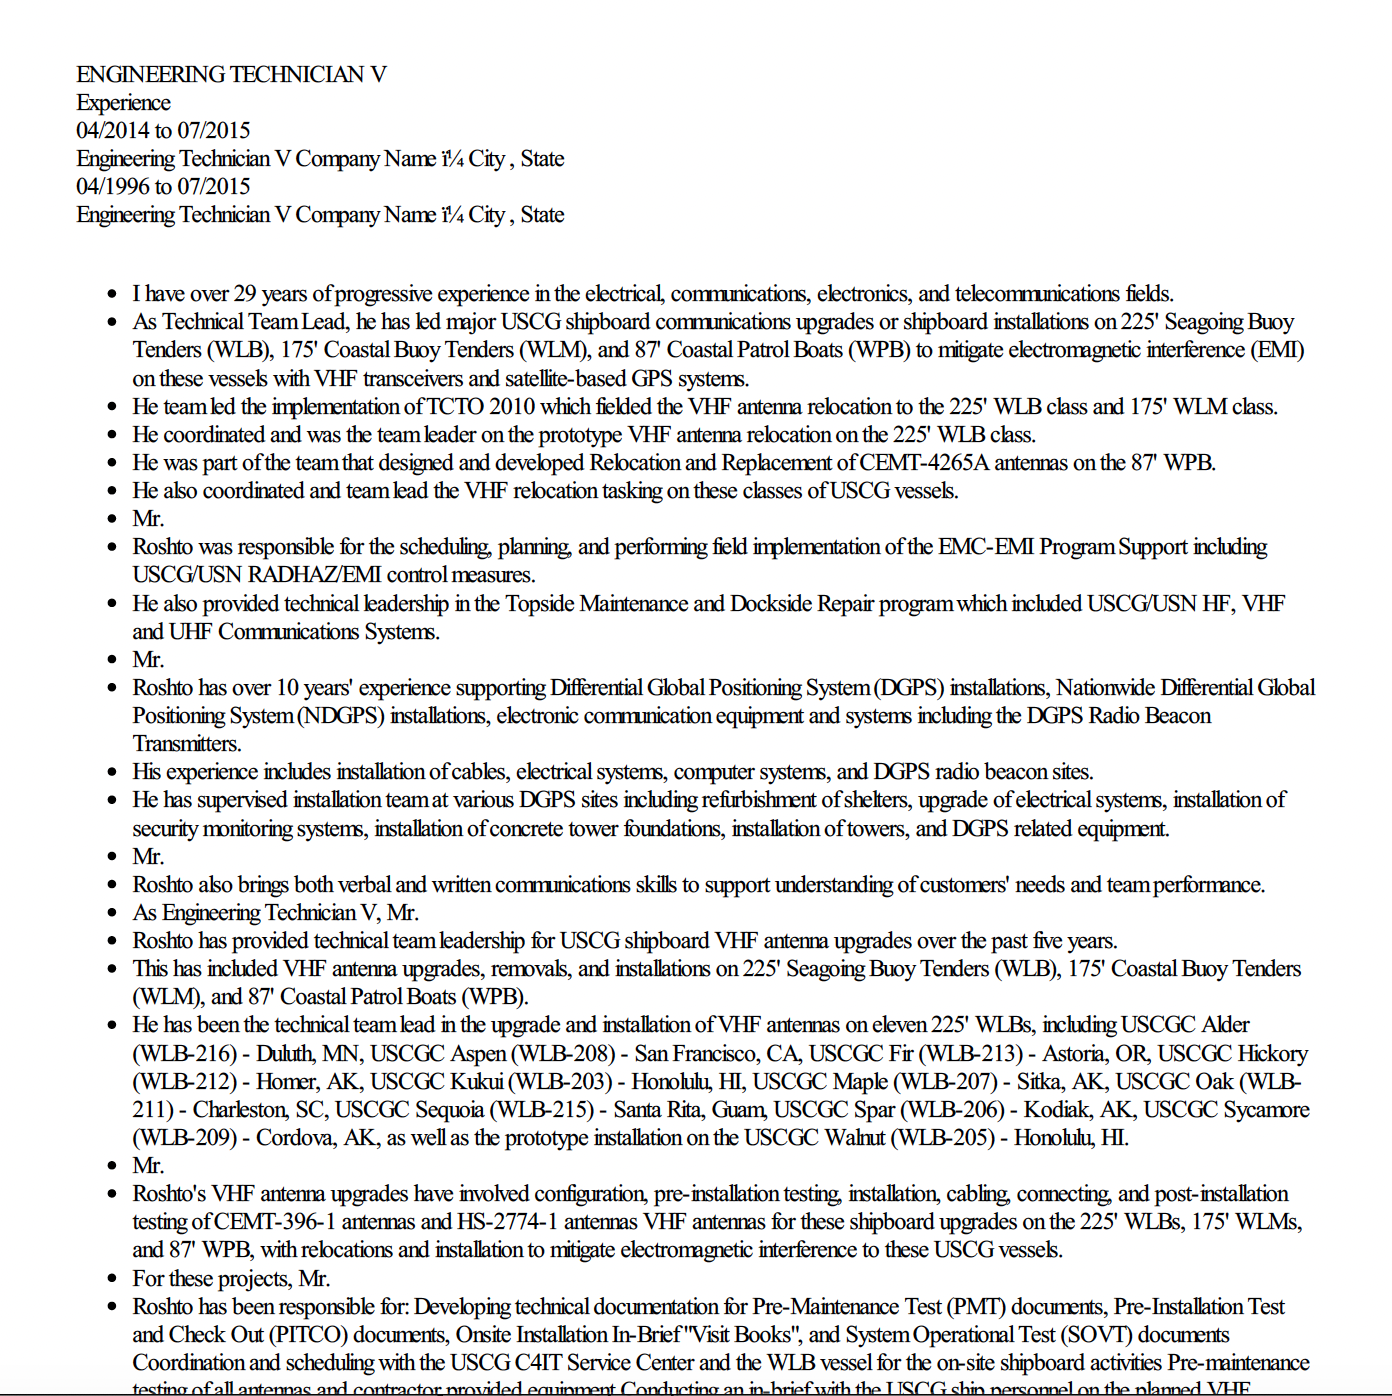

We also plan to refine our Experiment 1, where we break our words of "gender" "religion" and "race" into subcategories like we did in experiment 2 - 4. and we will instead of measure the sentiment score, measure the difference in the sentiment score with and without the targeted words.

We also plan to break down our experiment 2 to break that into deeper subcategories of "White Male names" and "White Female names" and so on.